# Explore Differential Privacy

A machine learning project typically involves an iterative process of data analyses in order to gain insights into the data and determine which variables are most likely to help build predictive models. Analyzing data usually involves aggregative and statistical functions that provide insights into the statistical distribution of variables and the relationships between them. With large volumes of data, the aggregations provide a level of abstraction; but with smaller amounts of data, or with repeated analyses, even aggregated results may reveal details about individual observations.

*Differential privacy* is a technique that is designed to preserve the privacy of individual data points by adding "noise" to the data. The goal is to ensure that enough noise is added to provide privacy for individual values while ensuring that the overall statistical makeup of the data remains consistent, and aggregations produce statistically similar results as when used with the original raw data.

## Install the SmartNoise SDK

[*SmartNoise*](https://smartnoise.org/) is a toolkit from OpenDP; a joint project between researchers at Microsoft, Harvard University, and other contributors that aims to provide building blocks for using differential privacy in data analysis and machine learning projects.

> **Note**: SmartNoise is in the early stages of development at this time.

Let's start by installing the SmartNoise Python SDK package. You can ignore any errors about Azure CLI compatibility in this excercise.

In [1]:
!pip install opendp-smartnoise==0.1.4.2

     |████████████████████████████████| 193 kB 19.0 MB/s eta 0:00:01
     |████████████████████████████████| 12.7 MB 27.7 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 46.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 34.8 MB/s eta 0:00:01
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141229 sha256=32dde9ed09ea9a13bbafd066442b7700a0b194fe954550100cd80bb5fb454fa3
  Stored in directory: /home/azureuser/.cache/pip/wheels/a8/04/35/9449686f1c26ff16f6224dc942e108329f3782185802ec6b93
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26818 sha256=89501e0958d691a4615da03b30077499973e2640653a0b334c85bce367ae114f
  Stored in directory: /home/azureuser/.cache/pip/wheels/a6/64/11/62d5f7b88421a5d80068ac9937fe2915e497da3eba900c8f59
Successfully built antlr4-python3-runtime pandasql
ERROR: azure-cli 2.24.0 has requirement antlr4-python3-runtime~=4.7.2, but you'll have antlr4-python3-r

## Load data

Now, let's take a look at some raw data. In this case, we have a set of 10,000 records for patients who have been tested for diabetes.

In [2]:
import pandas as pd

data_path = 'data/diabetes.csv'
diabetes = pd.read_csv(data_path)
diabetes.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.000000e+04,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.502122e+06,3.25580,107.850200,71.207500,28.81760,139.243600,31.567022,0.400944,30.134100,0.334400
std,2.892868e+05,3.40572,31.920909,16.801478,14.50648,133.777919,9.804366,0.381463,12.106047,0.471804
min,1.000038e+06,0.00000,44.000000,24.000000,7.00000,14.000000,18.200807,0.078044,21.000000,0.000000
25%,1.251672e+06,0.00000,84.000000,58.000000,15.00000,39.000000,21.247427,0.137065,22.000000,0.000000
50%,1.504394e+06,2.00000,105.000000,72.000000,31.00000,85.000000,31.922421,0.199698,24.000000,0.000000
75%,1.754608e+06,6.00000,129.000000,85.000000,41.00000,197.000000,39.328921,0.621158,35.000000,1.000000
max,1.999997e+06,14.00000,192.000000,117.000000,92.00000,796.000000,56.034628,2.301594,77.000000,1.000000


The output from the code above shows the key summary statistics for the variables in the diabetes dataset.

## Perform an analysis

You can use SmartNoise to create an analysis in which noise is added to the source data. The underlying mathematics of how the noise is added can be quite complex, but SmartNoise takes care of most of the details for you. However, there are a few concepts it's useful to be aware of.

- **Upper and lower bounds**: *Clamping* is used to set upper and lower bounds on values for a variable. This is required to ensure that the noise generated by SmartNoise is consistent with the expected distribution of the original data.
- **Sample size**: To generate consistent differentially private data for some aggregations, SmartNoise needs to know the size of the data sample to be generated.
- **Epsilon**: Put simplistically, *epsilon* is a non-negative value that provides an inverse measure of the amount of noise added to the data. A low epsilon results in a dataset with a greater level of privacy, while a high epsilon results in a dataset that is closer to the original data. Generally, you should use epsilon values between 0 and 1. Epsilon is correlated with another value named *delta*, that indicates the probability that a report generated by an analysis is not fully private.

With these concepts in mind, examine and run the following code, which creates an analysis and reports the mean **Age** value from the differentially private data. The actual mean value from the original raw data is also shown for comparison.

In [3]:
import opendp.smartnoise.core as sn

cols = list(diabetes.columns)
age_range = [0.0, 120.0]
samples = len(diabetes)

with sn.Analysis() as analysis:
    # load data
    data = sn.Dataset(path=data_path, column_names=cols)
    
    # Convert Age to float
    age_dt = sn.to_float(data['Age'])
    
    # get mean of age
    age_mean = sn.dp_mean(data = age_dt,
                          privacy_usage = {'epsilon': .50},
                          data_lower = age_range[0],
                          data_upper = age_range[1],
                          data_rows = samples
                         )
    
analysis.release()

# print differentially private estimate of mean age
print("Private mean age:",age_mean.value)

# print actual mean age
print("Actual mean age:",diabetes.Age.mean())

Private mean age: 30.096
Actual mean age: 30.1341


## Explore data distribution with histograms

It's common when analyzing data to examine the distribution of a variable using a histogram.

For example, let's look at the true distribution of ages in the diabetes dataset.

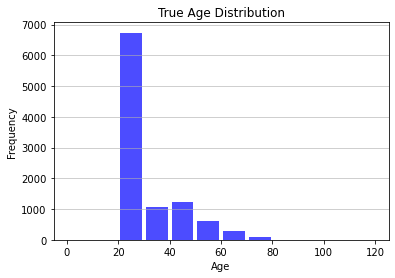

[   0    0 6735 1074 1229  614  273   75    0    0    0    0]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

ages = list(range(0, 130, 10))
age = diabetes.Age

# Plot a histogram with 10-year bins
n_age, bins, patches = plt.hist(age, bins=ages, color='blue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('True Age Distribution')
plt.show()
print(n_age.astype(int))

Now let's compare that a differentially private histogram of Age.

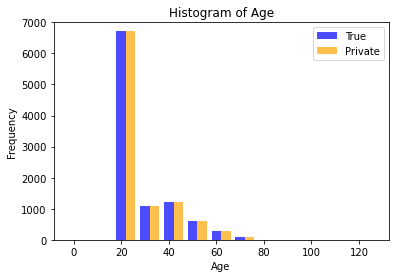

[   2    3 6732 1077 1230  611  274   76    3    4    0    0    1]


In [5]:
import matplotlib.pyplot as plt

with sn.Analysis() as analysis:
    data = sn.Dataset(path = data_path, column_names = cols)

    age_histogram = sn.dp_histogram(
            sn.to_int(data['Age'], lower=0, upper=120),
            edges = ages,
            upper = 10000,
            null_value = -1,
            privacy_usage = {'epsilon': 0.5}
        )
    
analysis.release()

plt.ylim([0,7000])
width=4
agecat_left = [x + width for x in ages]
agecat_right = [x + 2*width for x in ages]
plt.bar(list(range(0,120,10)), n_age, width=width, color='blue', alpha=0.7, label='True')
plt.bar(agecat_left, age_histogram.value, width=width, color='orange', alpha=0.7, label='Private')
plt.legend()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

print(age_histogram.value)

The histograms are similar enough to ensure that reports based on the differentially private data provide the same insights as reports from the raw data.

## Calculating covariance

Another common goal of analysis is to establish relationships between variables. SmartNoise provides a differentially private *covariance* function that can help with this.

In [6]:
with sn.Analysis() as analysis:
    sn_data = sn.Dataset(path = data_path, column_names = cols)

    age_bp_cov_scalar = sn.dp_covariance(
                left = sn.to_float(sn_data['Age']),
                right = sn.to_float(sn_data['DiastolicBloodPressure']),
                privacy_usage = {'epsilon': 1.0},
                left_lower = 0.,
                left_upper = 120.,
                left_rows = 10000,
                right_lower = 0.,
                right_upper = 150.,
                right_rows = 10000)
analysis.release()
print('Differentially private covariance: {0}'.format(age_bp_cov_scalar.value[0][0]))
print('Actual covariance', diabetes.Age.cov(diabetes.DiastolicBloodPressure))

Differentially private covariance: 0.0
Actual covariance 8.720346284628466


In this case, the covariance between **Age** and **DisatolicBloodPressure** is positive, indicating that older patients tend to have higher blood pressure.

## Use SQL queries

In addition to the **Analysis** functionality, SmartNoise enables you to use SQL queries against data sources to retrieve differentially private aggregated results.

First, you need to define the metadata for the tables in your data schema. You can do this in a .yml file, such as the **diabetes.yml** file in the **/metadata** folder. The metadata describes the fields in the tables, including data types and minimum and maximum values for numeric fields.

In [7]:
from opendp.smartnoise.metadata import CollectionMetadata

meta = CollectionMetadata.from_file('metadata/diabetes.yml')
print (meta)

diabetes.diabetes [10000 rows]
	*PatientID [int] (unbounded)
	Pregnancies [int] (0,20)
	PlasmaGlucose [float] (0.0,200.0)
	DiastolicBloodPressure [float] (0.0,150.0)
	TricepsThickness [float] (0.0,100.0)
	SerumInsulin [float] (0.0,1000.0)
	BMI [float] (0.0,100.0)
	DiabetesPedigree [float] (0.0,3.0)
	Age [int] (0,120)
	Diabetic (boolean)


With the metadata defined, you can create *readers* that you can query. In the following example, we'll create a **PandasReader** to read the raw data from a Pandas dataframe, and a **PrivateReader** that adds a differential privacy layer to the **PandasReader**.

In [8]:
from opendp.smartnoise.sql import PandasReader, PrivateReader

reader = PandasReader(diabetes, meta)
private_reader = PrivateReader(reader=reader, metadata=meta, epsilon_per_column=0.7)
print('Readers ready.')

Readers ready.


Now you can submit a SQL query that returns an aggregated resultset to the private reader.

In [9]:
query = 'SELECT Diabetic, AVG(Age) AS AvgAge FROM diabetes.diabetes GROUP BY Diabetic'

result_dp = private_reader.execute(query)
print(result_dp)

[['Diabetic', 'AvgAge'], [False, 27.17216702849511], [True, 36.455730584023506]]


Let's compare the result to the same aggregation from the raw data.

In [ ]:
result = reader.execute(query)
print(result)

You can customize the behavior of a **PrivateReader** with the **epsilon_per_column parameter**.

Let's try a reader with a high epsilon (low privacy) value, and another with a low epsilon (high privacy) value.

In [ ]:
low_privacy_reader = PrivateReader(reader, meta, 5.0)  # large epsilon, less privacy
result = low_privacy_reader.execute(query)
print(result)
print()

high_privacy_reader = PrivateReader(reader, meta, 0.1)  # smaller epsilon, more privacy
result = high_privacy_reader.execute(query)
print(result)

Note that the results of the high epsilon (low privacy) reader are closer to the true results from the raw data than the results from the low epsilon (high privacy) reader.

## Learn more

To learn more about differential privacy with SmartNoise, see [https://smartnoise.org](https://smartnoise.org/)